## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

### Load Datasets

In [2]:
# load dataset

data_dir='/home/acer/Desktop/_DATASETS/__ML/'
data = pd.read_csv(data_dir+'housing_train.csv')


In [3]:
data.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [4]:
print(sorted(data.columns))

['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SalePrice', 'SaleType', 'ScreenPorch', 'Street'

### Engineer new variables

In [5]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

In [6]:
# drop YrSold
data.drop('YrSold', axis=1, inplace=True)

In [7]:
data['total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] +
                                 data['1stFlrSF'] + data['2ndFlrSF'])

data['total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +
                              data['EnclosedPorch'] + data['ScreenPorch'] +
                              data['WoodDeckSF'])
data['has_2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)


### Make lists of variable types

In [8]:
categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 20 continuous variables
There are 15 discrete variables
There are 3 temporal variables
There are 43 categorical variables


### Separate train and test set

In [9]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

## A first pipeline

### Check and correct variable types

In [10]:
set(X_train.columns) - set(numerical+discrete+categorical)

{'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'}

In [11]:
discrete+=['GarageYrBlt', 'YearBuilt']
numerical+=['YearRemodAdd']
set(X_train.columns) - set(numerical+discrete+categorical)

set()

In [12]:
len(discrete+numerical+categorical), X_train.shape[1]

(81, 81)

In [13]:
# Selecting extremley skewed variables to be discetized
vars_to_discretize = ["3SsnPorch","BsmtFinSF2","EnclosedPorch","LotArea","LowQualFinSF","MiscVal","ScreenPorch"]

### First pipeline

In [14]:
from category_encoders.binary import BinaryEncoder
from category_encoders.hashing import HashingEncoder
from feature_engine import variable_transformers as vt
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')
house_pipe = Pipeline([

    # missing data imputation - section 4
    #('missing_ind', mdi.AddMissingIndicator(variables=numerical+discrete)),
    ('missing_ind', mdi.AddMissingIndicator()),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median', variables=numerical+discrete)),
    ('imputer_cat', mdi.CategoricalVariableImputer(imputation_method='missing', variables=categorical)),
    

    # categorical encoding - section 6
    ('rare_label_enc', ce.RareLabelCategoricalEncoder(
        tol=0.01, n_categories=6, variables=categorical)),

    ('categorical_enc',
     BinaryEncoder(cols=categorical)),
     #ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', variables=categorical)),
     #ce.OneHotCategoricalEncoder(top_categories=10, variables=categorical)),
     #HashingEncoder(cols=categorical)),
     #ce.MeanCategoricalEncoder(variables=categorical)),

    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=15,
                                   return_object=True,
                                   variables=vars_to_discretize)),
     #KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')),
     #dsc.EqualWidthDiscretiser(bins=30,
                                   #variables=vars_to_discretize)),
     #vt.YeoJohnsonTransformer(variables = vars_to_discretize)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=vars_to_discretize)),

    #feature Scaling - section 10
    ('scaler', MinMaxScaler()),
    
    # regression
    ('lasso', Lasso(random_state=0))
])


In [15]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

### Success!!!

In [16]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 629423285.1003836
train rmse: 25088.309729839984
train r2: 0.8991927877716274

test mse: 950325431.1036446
test rmse: 30827.34875242509
test r2: 0.8617128218221541


Text(0, 0.5, 'Predicted Price')

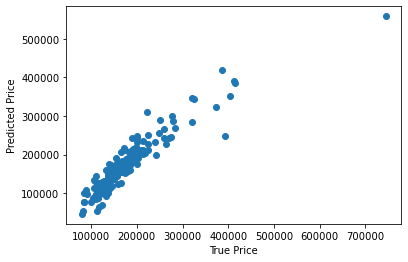

In [17]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

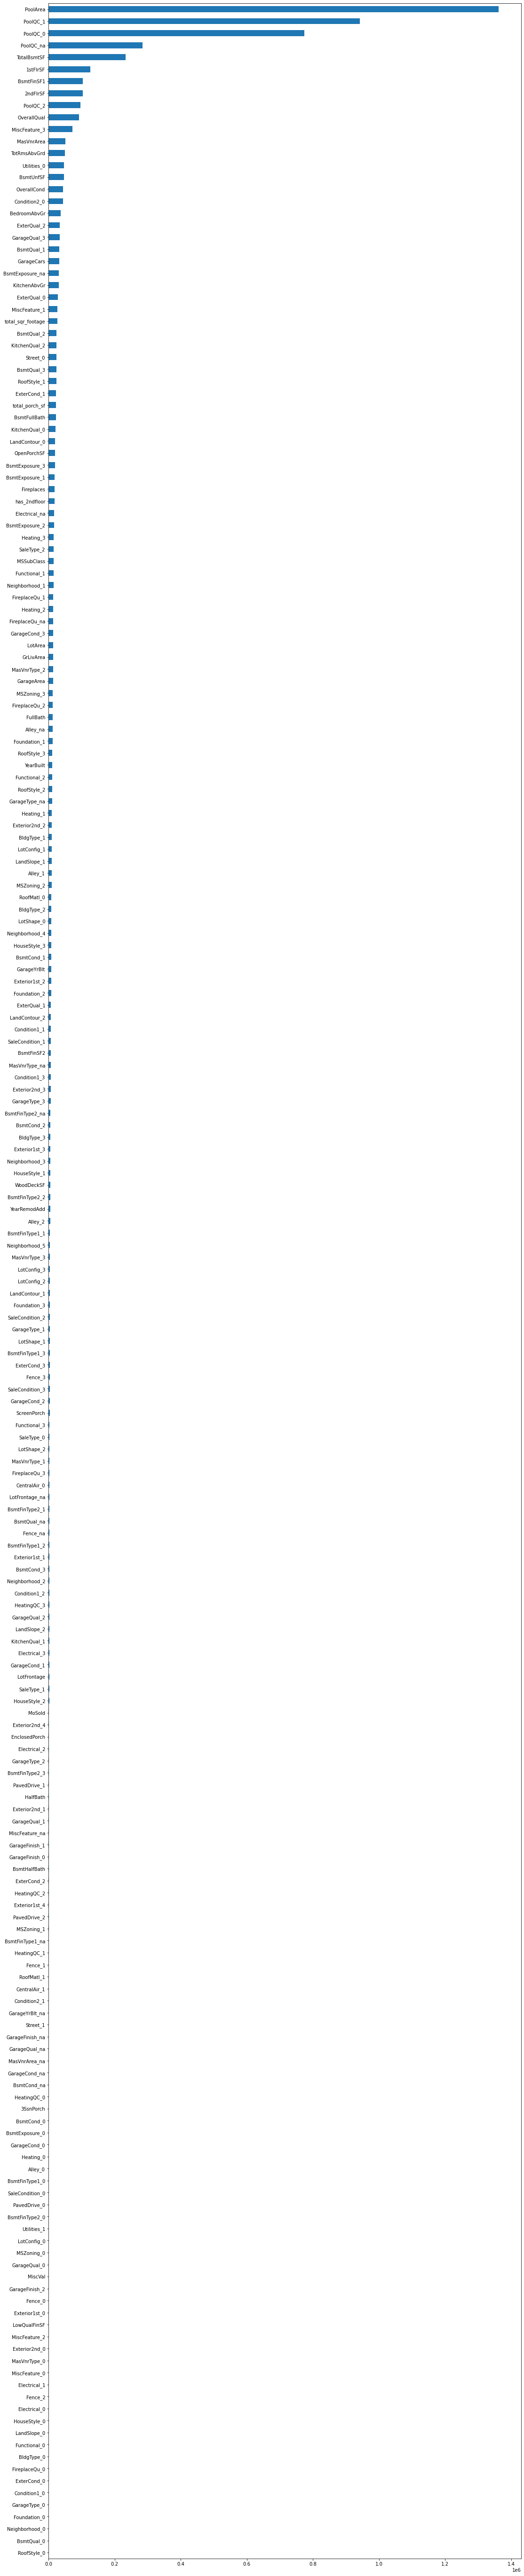

In [18]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
#print(importance[importance > 0.01])
importance.index = house_pipe['categorical_enc'].get_feature_names()
importance.sort_values(inplace=True)
importance.plot.barh(figsize=(18,100));

## Doing better with less variables

It is not always prudent to claim that one can do more with less. But if such claims can be proven, then I guess it is OK to at least try that.

- A model with so many variables is hard to interprete and prone to overfitting. 
- We also noticed in the plot of the feature importances above that the feature importance of the features is quite variable and in some cases apparently negligible. Some of them could perhaps be removed without unduly affecting the performance of the model. 
- In a best case scenario, the performance of the model might even be improved by such a removal.

### Selecting features using lasso feature importances

Let's describe statistically the feature importances returned by the Lasso model:

In [19]:
importance.mean(), importance.std(), importance.max(), importance.min()

(27332.669976823592, 126916.85196321027, 1361949.5913094603, 0.0)

After some trial and error, I found that a threshold of 10500 (for the value of the feature importances below which variables are removed) works quite well:

In [20]:
importance_threshold=10500 #10500 best
np.round(importance[importance > importance_threshold],3)

Functional_2      10606.057
YearBuilt         10659.399
RoofStyle_3       11066.197
Foundation_1      11682.206
Alley_na          12367.130
                   ...     
TotalBsmtSF      233584.810
PoolQC_na        283937.175
PoolQC_0         773544.112
PoolQC_1         942659.996
PoolArea        1361949.591
Length: 65, dtype: float64

A number of 68 variables is still excessive, but we are being asked to beat Soledad score ;-). I did try just 8 variables, but the r2 score was disappointing :-(. Anyway, modern computers seem to tolerate quite well models with just 68 variables, even if our understanding of the model might irretrievably suffer.

Then I collect the names of the 68 features that will remain on the model.

In [21]:
best_cols=importance[importance>importance_threshold].index.tolist()
print(best_cols)

['Functional_2', 'YearBuilt', 'RoofStyle_3', 'Foundation_1', 'Alley_na', 'FullBath', 'FireplaceQu_2', 'MSZoning_3', 'GarageArea', 'MasVnrType_2', 'GrLivArea', 'LotArea', 'GarageCond_3', 'FireplaceQu_na', 'Heating_2', 'FireplaceQu_1', 'Neighborhood_1', 'Functional_1', 'MSSubClass', 'SaleType_2', 'Heating_3', 'BsmtExposure_2', 'Electrical_na', 'has_2ndfloor', 'Fireplaces', 'BsmtExposure_1', 'BsmtExposure_3', 'OpenPorchSF', 'LandContour_0', 'KitchenQual_0', 'BsmtFullBath', 'total_porch_sf', 'ExterCond_1', 'RoofStyle_1', 'BsmtQual_3', 'Street_0', 'KitchenQual_2', 'BsmtQual_2', 'total_sqr_footage', 'MiscFeature_1', 'ExterQual_0', 'KitchenAbvGr', 'BsmtExposure_na', 'GarageCars', 'BsmtQual_1', 'GarageQual_3', 'ExterQual_2', 'BedroomAbvGr', 'Condition2_0', 'OverallCond', 'BsmtUnfSF', 'Utilities_0', 'TotRmsAbvGrd', 'MasVnrArea', 'MiscFeature_3', 'OverallQual', 'PoolQC_2', '2ndFlrSF', 'BsmtFinSF1', '1stFlrSF', 'TotalBsmtSF', 'PoolQC_na', 'PoolQC_0', 'PoolQC_1', 'PoolArea']


### Getting the dataframes as transformed by the pipeline

As can be noticed, some of the features that should be used in the more compact the model were created by the preceding `house_pipe` pipeline and did not exist in either X_train or X_test, which needed to be transformed for them to be created. 

In order to recover the dataframe with all the new variables created by applying the `house_pipe` pipeline, in retrospect it would have been easier to divide the original `house_pipe` pipeline into 2 succesive pipelines: 
- one that applied all the transformers, from which, via `fit()` and then `transform()` operations, we could get the X_train_tr and X_test_tr, the dataframes with all the newly created variables
- a second pipeline consisting only of the lasso step applied to the variables of X_train_tr that have a feature importance higher than 10500, the importance_threshold.

Let's start with the first of these 2 pipelines:

In [22]:
from category_encoders.binary import BinaryEncoder
from category_encoders.hashing import HashingEncoder
from feature_engine import variable_transformers as vt
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')
house_pipe_first = Pipeline([

    # missing data imputation - section 4
    #('missing_ind', mdi.AddMissingIndicator(variables=numerical+discrete)),
    ('missing_ind', mdi.AddMissingIndicator()),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median', variables=numerical+discrete)),
    ('imputer_cat', mdi.CategoricalVariableImputer(imputation_method='missing', variables=categorical)),
    

    # categorical encoding - section 6
    ('rare_label_enc', ce.RareLabelCategoricalEncoder(
        tol=0.01, n_categories=6, variables=categorical)),

    ('categorical_enc',
     BinaryEncoder(cols=categorical)),
     #ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', variables=categorical)),
     #ce.OneHotCategoricalEncoder(top_categories=10, variables=categorical)),
     #HashingEncoder(cols=categorical)),
     #ce.MeanCategoricalEncoder(variables=categorical)),

    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=15,
                                   return_object=True,
                                   variables=vars_to_discretize)),
     #KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')),
     #dsc.EqualWidthDiscretiser(bins=30,
                                   #variables=vars_to_discretize)),
     #vt.YeoJohnsonTransformer(variables = vars_to_discretize)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=vars_to_discretize)),

    #feature Scaling - section 10
    ('scaler', MinMaxScaler()),
    
    # regression
    #('lasso', Lasso(random_state=0))
])


Now apply this new `house_pipe_first` pipeline to both X_train and X_test in order to recover the transformed data frames. They will later be fed to the lasso step of the `house_price` pipeline.

In [23]:
X_train_tr=house_pipe_first.fit_transform(X_train, y_train)
X_test_tr=house_pipe_first.transform(X_test)

### Reducing the number of total features

In order to diminish the number of independent variables,  I arbitrarily choose (after some playing with the code) those that have a feature importance of >= 10500. For that, I select in X_train_tr and X_test_tr all the features that have a feature importance > 10500 (whose names I previously stored in best_cols). 

In [24]:
X_train_tr=pd.DataFrame(X_train_tr, columns=house_pipe['categorical_enc'].get_feature_names())[best_cols]
X_test_tr=pd.DataFrame(X_test_tr, columns=house_pipe['categorical_enc'].get_feature_names())[best_cols]
X_train_tr.shape, X_test_tr.shape

((1314, 65), (146, 65))

### Adjusting the lists of variable types

This operation changes the number of variables and it is therefore necessary to define the variable types currently in X_train_tr (and X_test_tr).

In [25]:
categorical = [var for var in X_train_tr.columns if X_train_tr[var].dtype == 'O']

discrete = [
    var for var in X_train_tr.columns if X_train_tr[var].dtype != 'O'
    and len(X_train_tr[var].unique()) < 20
]

numerical = [
    var for var in X_train_tr.columns if X_train_tr[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} categorical variables'.format(len(categorical)))

There are 11 continuous variables
There are 53 discrete variables
There are 0 categorical variables


Let's make sure that all available variables are being used:

In [26]:
set(X_train_tr.columns) - set(numerical+discrete+categorical)

{'YearBuilt'}

Well, they aren't, but we can quickly correct the situation:

In [27]:
numerical+=['YearBuilt']

The vars to discretize could also have been changed, and we just update them so that they indeed match the variables available in X_train_tr.

In [28]:
vars_to_discretize=[var for var in vars_to_discretize if var in X_train_tr.columns]
vars_to_discretize

['LotArea']

### Applying the final lasso step

The only thing that remains to be done is to feed the newly created X_train_tr dataframe to the final lasso step of our original `house_pipe` pipeline.

In [29]:
from category_encoders.binary import BinaryEncoder
from category_encoders.hashing import HashingEncoder
from feature_engine import variable_transformers as vt
from sklearn.preprocessing import KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')
house_pipe_second = Pipeline([

    # regression
    ('lasso', Lasso(random_state=0))
])


In [30]:
# let's fit the pipeline
house_pipe_second.fit(X_train_tr, y_train)

# let's get the predictions
X_train_preds = house_pipe_second.predict(X_train_tr)
X_test_preds = house_pipe_second.predict(X_test_tr)

### Even more success!!!

In [31]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 728460476.0962812
train rmse: 26990.00696732554
train r2: 0.8833311833989308

test mse: 918022221.3786224
test rmse: 30298.881520257844
test r2: 0.8664134428649612


We got a test r2 score of 0.8664. Furthermore, we have apparently reduced the overfitting (training and test r2 scores became much more similar). 

This is slightly better than the model with the full set of variables (whose test r2 score was 0.8617) and much better than the score of the initial model whose performance was meant to be improved (with a test r2 score = 0.7079).